In [2]:
import pandas as pd
import openpyxl
import h5py
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
import sys
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Experiment Hyperparameters

In [3]:
is_local = True # todo

# Experiment
seed = 1000 if is_local else int(sys.argv[-2])
torch.manual_seed(seed)
image_size = 256

# Data: which wavenumbers are even allowed to be considered?
wv_start = 0
wv_end = 965

# Data loading
test_set_fraction = 0.2
val_set_fraction = 0.2
batch_size= 2 # todo see how high can get on csf
use_augmentation = True

# Network
dropout_p=0

# Training schedule
lr = 1e-5
l2 = 5e-2
max_epochs=200

# dimensionality reduction parameters
r_method = 'linear' # {'linear','pca,'fixed'}
reduce_dim = 16 if is_local else int(sys.argv[-1]) 
channels_used = np.s_[...,wv_start:wv_end] # used only when r_method = 'fixed'

In [4]:
def csf_fp(filepath):
    return filepath.replace('D:/datasets','D:/datasets' if is_local else './')

master = pd.read_excel(csf_fp(rf'D:/datasets/pcuk2023_ftir_whole_core/master_sheet.xlsx'))
slide = master['slide'].to_numpy()
patient_id = master['patient_id'].to_numpy()
hdf5_filepaths = np.array([csf_fp(fp) for fp in master['hdf5_filepath']])
annotation_filepaths = np.array([csf_fp(fp) for fp in master['annotation_filepath']])
mask_filepaths = np.array([csf_fp(fp) for fp in master['mask_filepath']])
wavenumbers = np.load(csf_fp(f'D:/datasets/pcuk2023_ftir_whole_core/wavenumbers.npy'))[wv_start:wv_end]
wavenumbers_used = wavenumbers[channels_used]

annotation_class_colors = np.array([[0,255,0],[128,0,128],[255,0,255],[0,0,255],[255,165,0],[255,0,0]])
annotation_class_names = np.array(['epithelium_n','stroma_n','epithelium_c','stroma_c','corpora_amylacea','blood'])
n_classes = len(annotation_class_names)
print(f"Loaded {len(slide)} cores")
print(f"Using {len(wavenumbers_used)}/{len(wavenumbers)} wavenumbers")

Loaded 228 cores
Using 965/965 wavenumbers


## Define Datasets, Dataloaders

In [5]:
unique_pids = np.unique(patient_id)
pids_trainval, pids_test, _, _ = train_test_split(
    unique_pids, np.zeros_like(unique_pids), test_size=test_set_fraction, random_state=seed)
pids_train, pids_val, _, _ = train_test_split(
    pids_trainval, np.zeros_like(pids_trainval), test_size=(val_set_fraction/(1-test_set_fraction)), random_state=seed)
where_train = np.where(np.isin(patient_id,pids_train))
where_val = np.where(np.isin(patient_id,pids_val))
where_test = np.where(np.isin(patient_id,pids_test))
print(f"Patients per data split:\n\tTRAIN: {len(where_train[0])}\n\tVAL: {len(where_val[0])}\n\tTEST: {len(where_test[0])}")

Patients per data split:
	TRAIN: 130
	VAL: 51
	TEST: 47


In [6]:
class ftir_annot_dataset(torch.utils.data.Dataset):
    def __init__(self, 
                 hdf5_filepaths, mask_filepaths, annotation_filepaths, channels_use, augment=False):
        self.hdf5_filepaths = hdf5_filepaths
        self.mask_filepaths = mask_filepaths
        self.annotation_filepaths = annotation_filepaths
        self.channels_use = channels_use
        self.augment=augment
        
        # class data
        self.annotation_class_colors = np.array([[0,255,0],[128,0,128],[255,0,255],[0,0,255],[255,165,0],[255,0,0]])
        self.annotation_class_names = np.array(['epithelium_n','stroma_n','epithelium_c','stroma_c','corpora_amylacea','blood'])
        
    def __len__(self):
        return len(self.hdf5_filepaths)
    
    # split annotations from H x W x 3 to C x H x W, one/zerohot along C dimension
    def split_annotations(self,annotations_img):
        split = torch.zeros((len(self.annotation_class_colors),*annotations_img.shape[:-1]))
        for c,col in enumerate(annotation_class_colors):
            split[c,:,:] = torch.from_numpy(np.all(annotations_img == self.annotation_class_colors[c],axis=-1)) 
        return split
        
    def __getitem__(self, idx):    
        
        # open hdf5 file
        hdf5_file = h5py.File(self.hdf5_filepaths[idx],'r')
        
        # get mask
        mask = torch.from_numpy(
            hdf5_file['mask'][:],
        ).unsqueeze(0)
        
        # get ftir
        ftir = torch.from_numpy(
            hdf5_file['spectra'][*self.channels_use],
        ).permute(2,0,1)
        hdf5_file.close()
        ftir *= mask
        
        # get annotations
        annotations = self.split_annotations(cv2.imread(self.annotation_filepaths[idx])[:,:,::-1])
        annotations *= mask
        has_annotations = annotations.sum(dim=0) != 0
        
        if self.augment:
            to_aug = torch.rand((2,))
            if to_aug[0] > 0.5: #hflip
                ftir = torch.flip(ftir, (-1,))
                annotations = torch.flip(annotations, (-1,))
                has_annotations = torch.flip(has_annotations, (-1,))
                mask = torch.flip(mask, (-1,))
            if to_aug[1] > 0.5: #vflip
                ftir = torch.flip(ftir, (-2,))
                annotations = torch.flip(annotations, (-2,))
                has_annotations = torch.flip(has_annotations, (-2,))
                mask = torch.flip(mask, (-2,))
        
        return ftir, annotations, mask, has_annotations

In [7]:
dataset_train = ftir_annot_dataset(
    hdf5_filepaths[where_train], mask_filepaths[where_train], annotation_filepaths[where_train], channels_used, augment=use_augmentation,
)
dataset_val = ftir_annot_dataset(
    hdf5_filepaths[where_val], mask_filepaths[where_val], annotation_filepaths[where_val], channels_used, augment=False,
)
dataset_test = ftir_annot_dataset(
    hdf5_filepaths[where_test], mask_filepaths[where_test], annotation_filepaths[where_test], channels_used, augment=False,
)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True,drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,shuffle=True,drop_last=True)
print(f"loader sizes:\n\ttrain: {len(train_loader)}\n\tval: {len(val_loader)}\n\ttest: {len(test_loader)}")

loader sizes:
	train: 65
	val: 25
	test: 23


## Define dimensionality reduction method

In [8]:
class LinearReduction(nn.Module):
    def __init__(self,input_dim,reduce_dim):
        super().__init__()
        self.reduce_dim = reduce_dim
        self.input_norm = nn.BatchNorm2d(input_dim)
        self.projection = nn.Conv2d(input_dim,reduce_dim,kernel_size=1,stride=1)
        self.projection_norm = nn.BatchNorm2d(reduce_dim)
    
    def forward(self,x):
        return self.projection_norm(self.projection(self.input_norm(x)))
    
class PCAReduce(nn.Module):
    def __init__(self,reduce_dim,means,loadings):
        super().__init__()
        self.reduce_dim = reduce_dim
        self.register_buffer('means', torch.from_numpy(means).float().reshape(1,-1,1,1))
        self.register_buffer('loadings', torch.from_numpy(loadings).float())
    
    def forward(self,x):
        projected = x - self.means
        
        b,c,h,w = projected.shape
        projected = projected.permute(0,2,3,1).reshape(b,h*w,c)
        projected = torch.matmul(projected, self.loadings.T)
        projected = projected.reshape(b,h,w,self.reduce_dim).permute(0,3,1,2)
        
        return projected
        
class FixedReduction(nn.Module):
    def __init__(self,input_dim):
        super().__init__()
        self.input_norm = nn.BatchNorm2d(input_dim)
    
    def forward(self,x):
        return self.input_norm(x)

if r_method == 'pca':
    spectral_sample = []
    batch_samples = 0
    for data, annotations, mask, has_annotations in train_loader:
        where = torch.where(has_annotations[0] == 1)
        ridxs = torch.randperm(where[0].shape[0])[:100]
        spectral_sample.append(data[:, :, where[0][ridxs],where[1][ridxs]].permute(0,2,1).flatten(0,1).numpy())
        batch_samples += 1
        if batch_samples > 10: break
    spectral_sample = np.concatenate(spectral_sample,axis=0)
    spectral_means = np.mean(spectral_sample,axis=0)
    spectral_sample -= spectral_means
    pca = PCA(n_components=reduce_dim)
    pca.fit(spectral_sample)
    spectral_loadings = pca.components_

## Define Model

In [9]:
import torchvision
class SegViT(torchvision.models.VisionTransformer):
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        if r_method == 'pca':
            self.input_processing = PCAReduce(reduce_dim,spectral_means,spectral_loadings)
        elif r_method == 'fixed':
            self.input_processing = FixedReduction(input_dim=len(wavenumbers_used))
        elif r_method == 'linear':
            self.input_processing = LinearReduction(input_dim=len(wavenumbers_used),reduce_dim=reduce_dim)
            
        self.conv_proj = nn.Conv2d(
            in_channels=len(wavenumbers_used) if r_method == 'fixed' else reduce_dim, 
            out_channels=self.hidden_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size
        )
            
        self.upscale = nn.ConvTranspose2d(self.hidden_dim,self.hidden_dim,kernel_size=16,stride=16)
        self.heads = nn.Sequential(
            nn.Conv2d(self.hidden_dim + (len(wavenumbers_used) if r_method == 'fixed' else reduce_dim),self.hidden_dim//2,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(self.hidden_dim//2),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.hidden_dim//2,self.hidden_dim//4,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(self.hidden_dim//4),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.hidden_dim//4,n_classes,kernel_size=3,stride=1,padding=1),
        )
    
    def forward(self, x: torch.Tensor):
        b,c,h,w = x.shape
        hpatch,wpatch = h//self.patch_size,w//self.patch_size
        
        # Reshape and permute the input tensor
        x_in = self.input_processing(x)
        x = self._process_input(x_in)
        n = x.shape[0]
    
        # Expand the class token to the full batch
        batch_class_token = self.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)
    
        x = self.encoder(x)
    
        # Classifier "token" as used by standard language architectures
        # B x hpatch*wpatch x self.hidden_dim
        x = x[:, 1:].permute(0,2,1).reshape(b,self.hidden_dim,hpatch,wpatch)
        x = self.upscale(x)
        x = self.heads(torch.cat([x,x_in],dim=1))
    
        return x
    
model = SegViT(
    image_size=256,
    patch_size=16,
    num_layers=12,
    num_heads=12,
    hidden_dim=192,
    num_classes=n_classes,
    mlp_dim=192*4,
)

model = model.to(device)

## Training Loop

In [10]:
loss_fn = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=l2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=15, threshold=0.01, cooldown=0)

In [11]:
training_losses,validation_losses = [],[]
training_accs,validation_accs = [],[]
training_f1ms,validation_f1ms = [],[]
training_f1s,validation_f1s = [],[]
lr_decreases = []
current_iters = 0
best_val_f1 = 0
best_val_iter = 0
stop_training=False

In [12]:
for epoch in range(max_epochs):
    print(f"\n ✰ ✰ ✰ EPOCH {epoch+1} ✰ ✰ ✰ ")
    
    # reset running metrics
    running_loss_train, running_loss_val = 0, 0
    train_preds,train_targets = [],[]
    val_preds,val_targets = [],[]
    
    # Train loop
    model.train()
    batch_frac = 42 / (len(train_loader))
    for batch_idx, (data, annot, mask, has_annotations) in enumerate(train_loader):
        print(f"train : {'█'*int(batch_idx*batch_frac)}", end="\r")
        
        # Put data and label on device
        data = data.to(device); annot = annot.to(device); has_annotations = has_annotations.to(device)
        
        # Push data through model
        optimizer.zero_grad()
        out = model(data)
        
        # Calculate loss
        loss = loss_fn(out,annot.argmax(dim=1)) * has_annotations # loss per pixel
        loss = loss.sum() / (has_annotations.sum()) # mean loss per annotated pixel
        loss.backward() # backprop
        optimizer.step()
        
        # Calculate metrics
        running_loss_train += loss.cpu().item()
        targets = annot.argmax(dim=1)[has_annotations] # class targets on annotated pixels
        preds = out.argmax(dim=1)[has_annotations] # predicted values on annotated pixels
        train_preds.extend(preds.detach().cpu().numpy())
        train_targets.extend(targets.detach().cpu().numpy())
    print(f"train : {'█'*42}")
        
    # Validate loop
    model.eval()
    batch_frac = 42 / len(val_loader)
    with torch.no_grad():
        for batch_idx, (data, annot, mask, has_annotations) in enumerate(val_loader):
            print(f"val   : {'█'*int(batch_idx*batch_frac)}", end="\r")
            
            # Put data and label on device
            data = data.to(device); annot = annot.to(device); has_annotations = has_annotations.to(device)
            
            # Push data through model
            out = model(data)
            
            # Calculate loss
            loss = loss_fn(out,annot.argmax(dim=1)) * has_annotations # loss per pixel
            loss = loss.sum() / (has_annotations.sum()) # mean loss per annotated pixel
            
            # Calculate metrics
            running_loss_val += loss.cpu().item()
            targets = annot.argmax(dim=1)[has_annotations] # class targets on annotated pixels
            preds = out.argmax(dim=1)[has_annotations] # predicted values on annotated pixels
            val_preds.extend(preds.detach().cpu().numpy())
            val_targets.extend(targets.detach().cpu().numpy())
    print(f"val   : {'█'*42}")
    
    # calculate epoch metrics for train set
    train_acc = accuracy_score(train_targets, train_preds); training_accs.append(train_acc)
    train_f1m = f1_score(train_targets, train_preds, average='macro'); training_f1ms.append(train_f1m)
    train_f1 = f1_score(train_targets, train_preds, average=None); training_f1s.append(train_f1)
    train_loss = running_loss_train / (len(dataset_train)); training_losses.append(train_loss)
    
    # calculate epoch metrics for val set
    val_acc = accuracy_score(val_targets, val_preds); validation_accs.append(val_acc)
    val_f1m = f1_score(val_targets, val_preds, average='macro'); validation_f1ms.append(val_f1m)
    val_f1 = f1_score(val_targets, val_preds, average=None); validation_f1s.append(val_f1)
    val_loss = running_loss_val / (len(dataset_val)); validation_losses.append(val_loss)
    
    # Update
    print(f"TRAIN --- | Loss: {train_loss:.4} | OA: {train_acc:.4} | f1: {train_f1m:.4}")
    print(f"VAL ----- | Loss: {val_loss:.4} | OA: {val_acc:.4} | f1: {val_f1m:.4}")
    
    scheduler.step(val_f1m)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != lr:
        print(f"Val f1 plateaued, lr {lr} -> {new_lr}")
        lr = new_lr
        lr_decreases.append(epoch)
        if len(lr_decreases) >= 3: 
            print("Val f1 decreased thrice, ending training early")
            break

    if val_f1m > best_val_f1:
        best_val_f1 = val_f1m
        best_val_epoch = epoch
        if not is_local:
            torch.save(model.state_dict(), rf'./model_weights_{seed}.pt')

if not is_local:
    model.load_state_dict(torch.load(rf'./model_weights_{seed}.pt', weights_only=True))


 ✰ ✰ ✰ EPOCH 1 ✰ ✰ ✰ 


KeyboardInterrupt: 

## Test Loop

In [ ]:
# Test
running_loss_test = 0
test_preds, test_targets = [], []
model.eval()
with torch.no_grad():
    for batch_idx, (data, annot, mask, has_annotations) in enumerate(test_loader):
        # Put data and label on device
        data = data.to(device); annot = annot.to(device); has_annotations = has_annotations.to(device)
        
        # Push data through model
        out = model(data)
        
        # Calculate loss
        loss = loss_fn(out,annot.argmax(dim=1)) * has_annotations # loss per pixel
        loss = loss.sum() / (has_annotations.sum()) # mean loss per annotated pixel
        
        # Calculate metrics
        running_loss_test += loss.cpu().item()
        targets = annot.argmax(dim=1)[has_annotations] # class targets on annotated pixels
        preds = out.argmax(dim=1)[has_annotations] # predicted values on annotated pixels
        test_preds.extend(preds.detach().cpu().numpy())
        test_targets.extend(targets.detach().cpu().numpy())
        
        # Save pred figure todo remove
        if is_local:
            for b in range(data.shape[0]):
                bidx = (batch_idx*1) + b
                fig, ax = plt.subplots(figsize=(8, 4))
                predcore = annotation_class_colors[out[b].argmax(dim=0).detach().cpu().numpy()].reshape(256,256,3) / 255
                annotcolour = annotation_class_colors[annot[b].argmax(dim=0).cpu().numpy()] / 255
                predcore *= mask[b,0].cpu().numpy()[...,np.newaxis]
                annotcolour *= has_annotations[b].cpu().numpy()[...,np.newaxis]
                annotcolour += mask[b,0].cpu().numpy()[...,np.newaxis] * 1 - has_annotations[b].cpu().numpy()[...,np.newaxis]
                ax.imshow(np.hstack([predcore,annotcolour]))
                ax.set_axis_off()
                #ax.text(235, 220, dataset_test.hdf5_filepaths[bidx].split('/')[-1][:-3], fontsize=12, color='cyan', fontweight='bold')
                fig.tight_layout()

# calculate test set metrics
test_acc = accuracy_score(test_targets, test_preds)
test_f1m = f1_score(test_targets, test_preds, average='macro')
test_f1 = f1_score(test_targets, test_preds, average=None)
test_loss = running_loss_test / batch_idx

print(f"TEST ---- | Loss: {test_loss:.4} | OA: {test_acc:.4} | f1: {test_f1m:.4}")
for cls_idx, f1 in enumerate(test_f1):
    print(f"{annotation_class_names[cls_idx]}{(20 - len(annotation_class_names[cls_idx])) * ' '} : {f1:.4}")

## Evaluation

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(16,5))
ax[0].plot(np.arange(1,len(training_losses)+1),np.array(training_losses),color='cornflowerblue',label="train")
ax[0].plot(np.arange(1,len(validation_losses)+1),np.array(validation_losses),color='orange',label="validation")
ax[0].scatter(len(validation_losses),test_loss,color='green',label="test",marker="x")
ax[0].set_title("loss curves"); ax[0].legend()

ax[1].plot(np.arange(1,len(training_accs)+1),np.array(training_accs),color='cornflowerblue',label="train")
ax[1].plot(np.arange(1,len(validation_accs)+1),np.array(validation_accs),color='orange',label="validation")
ax[1].scatter(len(validation_losses),test_acc,color='green',label="test",marker="x")
ax[1].set_title("accuracy"); ax[1].legend()

ax[2].plot(np.arange(1,len(training_f1ms)+1),np.array(training_f1ms),color='cornflowerblue',label="train")
ax[2].plot(np.arange(1,len(validation_f1ms)+1),np.array(validation_f1ms),color='orange',label="validation")
ax[2].scatter(len(validation_losses),test_f1m,color='green',label="test",marker="x")
ax[2].set_title("macro f1"); ax[2].legend()

for lrd in lr_decreases:
    ax[0].axvline(x=lrd, ymin=0, ymax=1, color='grey')
    ax[1].axvline(x=lrd, ymin=0, ymax=1, color='grey')
    ax[2].axvline(x=lrd, ymin=0, ymax=1, color='grey')

ax[0].axvline(x=best_val_epoch, ymin=0, ymax=1, color='red',alpha=0.3)
ax[1].axvline(x=best_val_epoch, ymin=0, ymax=1, color='red',alpha=0.3)
ax[2].axvline(x=best_val_epoch, ymin=0, ymax=1, color='red',alpha=0.3)

plt.tight_layout()
if not is_local:
    plt.savefig(f'./loss_curve_{seed}.png')
    plt.close(fig)

In [ ]:
fig,ax = plt.subplots(2,3,figsize=(15,5)); ax = ax.flatten()
for cls in range(6):
    ax[cls].plot(np.arange(1,len(training_f1s)+1),[i[cls] for i in training_f1s], color='black', label="train")
    ax[cls].plot(np.arange(1,len(validation_f1s)+1),[i[cls] for i in validation_f1s], color=annotation_class_colors[cls]/255, label="val")
    ax[cls].set_title(f"{annotation_class_names[cls]}")
    ax[cls].legend()
    ax[cls].scatter(len(validation_losses),test_f1[cls],color='green',label="test",marker="x")
    for lrd in lr_decreases:
        ax[cls].axvline(x=lrd, ymin=0, ymax=1, color='grey')
    ax[cls].axvline(x=best_val_epoch, ymin=0, ymax=1, color='red',alpha=0.3)
fig.suptitle("Class-specific F1 scores")
plt.tight_layout()
if not is_local:
    plt.savefig(f'./loss_curve_by_class_{seed}.png')
    plt.close(fig)

## Finish experiment

In [ ]:
if not is_local:
    model = model.cpu()
    torch.save(model.state_dict(), rf'./model_weights_{seed}.pt')

In [ ]:
# Read existing results file
if not is_local:
    if os.path.isfile('results.txt'):
        f = open('results.txt','r')
        lines = f.readlines()
        f.close()
    else: 
        lines = [x+', \n' for x in['seed',*annotation_class_names,'overall_acc','macro_f1']]
        
    # Process files
    lines[0] = lines[0].replace('\n',str(seed) + ', \n')
    for cls in range(n_classes):
        lines[cls+1] = lines[cls+1].replace('\n',str(test_f1[cls]) + ', \n' )
    lines[n_classes+1] = lines[n_classes+1].replace('\n',str(test_acc) + ', \n')
    lines[n_classes+2] = lines[n_classes+2].replace('\n',str(test_f1m) + ', \n')
    
    f = open('results.txt','w')
    f.write(''.join(lines))
    f.close()

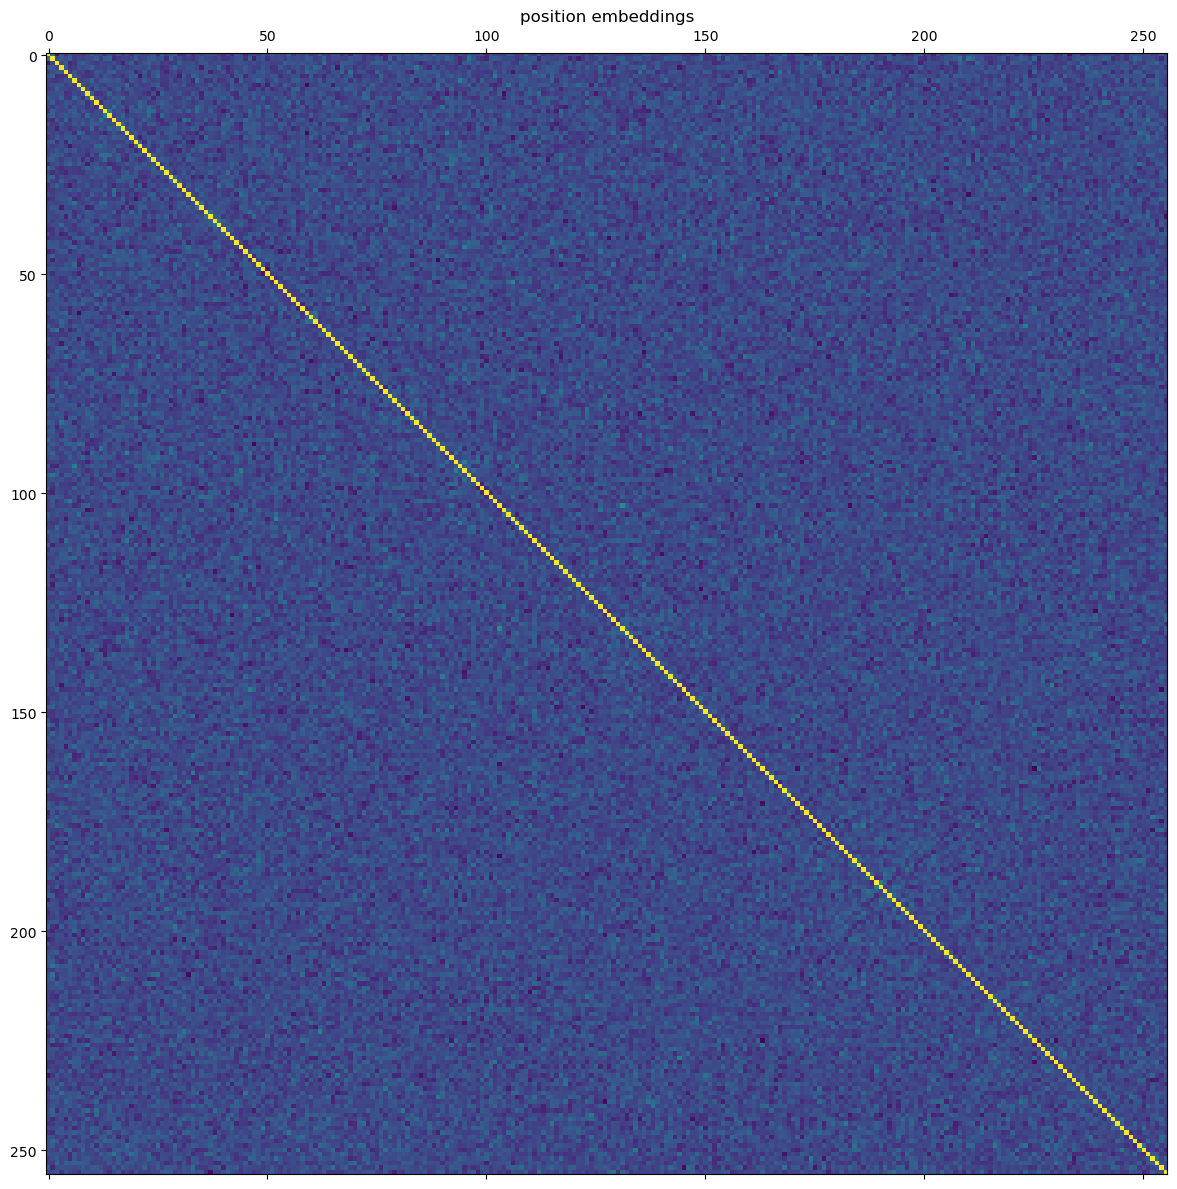

In [19]:
fig,ax = plt.subplots(figsize=(12,12))
locarray = np.zeros((model.encoder.pos_embedding.shape[1]-1,model.encoder.pos_embedding.shape[1]-1))
cos = nn.CosineSimilarity(dim=0)
for r in range(model.encoder.pos_embedding.shape[1]-1):
    for c in range(model.encoder.pos_embedding.shape[1]-1):
        locarray[r,c] = cos(model.encoder.pos_embedding[0][r + 1],model.encoder.pos_embedding[0][c + 1]).detach().cpu().numpy()
ax.set_title("position embeddings")
ax.matshow(locarray)
fig.tight_layout()
if not is_local:
    plt.savefig(f'./position_embedding_{seed}.png'); plt.close(fig) 